# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader as DataLoader
import torchvision as TV
from torchvision import transforms as TR
from torchvision import models
from datetime import datetime
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import math

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
image_size = 224
resize_size = image_size + 16
norm_means = [0.485, 0.456, 0.406]
norm_stds = [0.229, 0.224, 0.225]

train_transform = [TR.RandomRotation(degrees=10),
                   TR.RandomVerticalFlip(p=0.1),
                   TR.RandomResizedCrop(size=image_size, scale=(0.5, 1.5)),
                   TR.ToTensor(),
                   TR.Normalize(norm_means, norm_stds)]
train_transform = TR.Compose(train_transform)

test_transform = [TR.Resize(size=resize_size),
                  TR.CenterCrop(size=image_size),
                  TR.ToTensor(),
                  TR.Normalize(norm_means, norm_stds)]
test_transform = TR.Compose(test_transform)

eval_transform = test_transform

In [4]:
# TODO: Load the datasets with ImageFolder
batch_size = 64
def init_data_loader(data_dir, data_transform):
    data_set = TV.datasets.ImageFolder(data_dir, transform=data_transform)
    return data_set, DataLoader(data_set, batch_size, shuffle=True)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_data, train_loader = init_data_loader(train_dir, train_transform)
test_data, test_loader = init_data_loader(test_dir, test_transform)
eval_data, eval_loader = init_data_loader(valid_dir, eval_transform)

In [5]:
def check_loader(loader):
    images, labels = next(iter(loader))
    images_ok = images.shape == torch.Size([batch_size, 3, image_size, image_size])
    labels_ok = labels.shape == torch.Size([batch_size])
    assert images_ok and labels_ok, "Loader didn't serve correct batches!"
    print(len(loader))
    
check_loader(train_loader)
check_loader(test_loader)
check_loader(eval_loader)

103
13
13


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
# TODO: Build and train your network
def load_feature_detector():
    return TV.models.resnet50(pretrained=True)


pre_trained_model = load_feature_detector()

In [8]:
detector_feature_count = pre_trained_model.fc.in_features
category_count = len(cat_to_name)
print(f"Classifier input count = {detector_feature_count}")
print(f"Classifier output count = {category_count}")

Classifier input count = 2048
Classifier output count = 102


In [9]:
class FlowerClassifier(nn.Module):
    def __init__(self, x_count, h1_count, h2_count, output_count, dropout_prob):
        super().__init__()
        self.hidden1 = nn.Linear(x_count, h1_count)
        self.hidden2 = nn.Linear(h1_count, h2_count)
        self.output = nn.Linear(h2_count, output_count)
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, categories):
        h1 = self.dropout(F.relu(self.hidden1(categories)))
        h2 = self.dropout(F.relu(self.hidden2(h1)))
        out_logits = F.log_softmax(self.output(h2), dim=1)
        return out_logits

In [10]:
def disable_training(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

        
def check_training_disabled(model):
    is_trained = lambda param: param.requires_grad
    params = list(model.parameters())
    trained_params = list(filter(is_trained, params))
    return len(trained_params) == 0


def prepare_network(model):
    disable_training(model)
    assert check_training_disabled(model), "Model params not frozen!"
    model.fc = FlowerClassifier(detector_feature_count, 1024, 512, category_count, 0.05)
    return model


model = prepare_network(pre_trained_model)

In [11]:
def prepare_device():
    if (not torch.cuda.is_available()):
        print("No CUDA GPU found.")
        return torch.device("cpu")
    device_id = 0
    device = torch.device(f"cuda:{device_id}")
    count = torch.cuda.device_count()
    name = torch.cuda.get_device_name(device_id)
    capability = torch.cuda.get_device_capability(device_id)
    print(f"{count} CUDA GPUs available. Using {name} with CUDA {capability[0]}.{capability[1]} capability.")
    return device


def check_model_on_gpu(model):
    is_on_cpu = lambda param: param[0].device.type == "cpu"
    params = list(model.parameters())
    cpu_params = list(filter(is_on_cpu, params))
    assert len(cpu_params) == 0, "Model has not been moved to GPU!"
    print("Model is on GPU.")
    

device = prepare_device()
model.to(device)
check_model_on_gpu(model)

1 CUDA GPUs available. Using GeForce GTX 970 with CUDA 5.2 capability.
Model is on GPU.


In [12]:
learn_rate = 0.0003
optimizer = optim.Adam(params=model.fc.parameters(), lr=learn_rate)
#optimizer = optim.SGD(params=model.fc.parameters(), lr=learn_rate)
criterion = nn.NLLLoss()
epochs = 6

In [13]:
def run_training_step():
    model.train()
    avg_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        ouput_logits = model.forward(images)
        loss = criterion(input=ouput_logits, target=labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
    avg_loss /= len(train_loader)
    return avg_loss

In [14]:
def calculate_accuracy(logits, labels):
    predictions = torch.exp(logits)
    predicted_classes = torch.topk(input=predictions, k=1, dim=1)[1]
    resized_labels = labels.view(predicted_classes.shape[0], -1)
    prediction_matches = predicted_classes == resized_labels
    accuracy = torch.mean(prediction_matches.type(torch.FloatTensor))
    return accuracy


def run_evaluation_step(dataset_loader, model):
    model.eval()
    avg_loss = 0
    avg_accuracy = 0
    
    with torch.no_grad():
        for images, labels in dataset_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output_logits = model.forward(images)
            loss = criterion(input=output_logits, target=labels)
            accuracy = calculate_accuracy(output_logits,labels)
            
            avg_loss += loss
            avg_accuracy += accuracy
    
    avg_loss /= len(dataset_loader)
    avg_accuracy /= len(dataset_loader)
    return avg_loss, avg_accuracy

In [15]:
class ResultLogger():
    def __init__(self):
        self.file = None
        self.start_time = None
        
    
    def __format_hyperparams(self, batch_size, epoch_count, optimizer, lr):
        hyper_string = ("HYPERPARAMETERS"
                        "\n- batches: {0}"
                        "\n- epochs: {1}"
                        "\n- optimizer: {2}"
                        "\n- learning rate: {3}")
        return hyper_string.format(batch_size, epoch_count, optimizer, lr)
    
    
    def start_logging(self, file_name, batch_size, epoch_count, optimizer, lr):
        self.file = open(file_name, 'a')
        self.file.write("\nNN TRAINING LOG\n")
        self.file.write(datetime.now().strftime("%d.%m.%Y %H:%M:%S") + "\n")
        self.file.write("-------------------\n")
        self.file.write(self.__format_hyperparams(batch_size, epoch_count, type(optimizer), lr) + "\n\n")
        self.start_time = datetime.now()
    
    
    def __get_run_time(self):
        delta_t = datetime.now() - self.start_time
        return str(delta_t)
    
    
    def __print_epoch(self, epoch, train_loss, eval_loss, eval_accuracy):
        print(f"Epoch {epoch} [{self.__get_run_time()}]")
        print(f"Training loss: {train_loss:12.3f}")
        print(f"Evaluation loss: {eval_loss:10.3f}")
        print(f"Evaluation accuracy: {eval_accuracy*100:1.3f}%")
        
        
    def __write_epoch(self, epoch, train_loss, eval_loss, eval_accuracy):
        epoch_string = (f"EPOCH {epoch} [{self.__get_run_time()}]"
                        f"\n> tr loss: {train_loss:0.3f}"
                        f"\n> ev loss: {eval_loss:0.3f}"
                        f"\n> ev accu: {eval_accuracy*100:0.3f}%\n")
        self.file.write(epoch_string)
    
    
    def process_training_epoch(self, epoch, train_loss, eval_loss, eval_accuracy):
        self.__print_epoch(epoch, train_loss, eval_loss, eval_accuracy)
        self.__write_epoch(epoch, train_loss, eval_loss, eval_accuracy)
    
    
    def stop_logging(self):
        self.file.write(f"\nTotal run time: {self.__get_run_time()}\n")
        self.file.write(f"[x] END\n")
        self.file.close()

In [16]:
logger = ResultLogger()

def train_model():
    logger.start_logging("train_log.txt", batch_size, epochs, optimizer, learn_rate)
    for epoch in range(epochs):
        train_loss = run_training_step()
        eval_loss, eval_accuracy = run_evaluation_step(eval_loader, model)
        logger.process_training_epoch(epoch, train_loss, eval_loss, eval_accuracy)
    logger.stop_logging()
        

def is_saved_model_available(path):
    try:
        model_file = open(path, 'r')
    except IOError:
        return False
    else:
        model_file.close()
        return True


saved_model_path = "flower_classifier_checkpoint.pth"
if is_saved_model_available(saved_model_path):
    print("Saved model is available, skipping training.")
else:
    print("Beginning training...")
    check_model_on_gpu(model)
    train_model()

Beginning training...
Model is on GPU.
Epoch 0 [0:01:34.633581]
Training loss:        3.540
Evaluation loss:      2.042
Evaluation accuracy: 51.764%
Epoch 1 [0:03:07.245090]
Training loss:        1.524
Evaluation loss:      0.957
Evaluation accuracy: 77.034%
Epoch 2 [0:04:40.008978]
Training loss:        0.896
Evaluation loss:      0.669
Evaluation accuracy: 83.264%
Epoch 3 [0:06:12.856667]
Training loss:        0.667
Evaluation loss:      0.573
Evaluation accuracy: 84.740%
Epoch 4 [0:07:45.673228]
Training loss:        0.517
Evaluation loss:      0.420
Evaluation accuracy: 89.562%
Epoch 5 [0:09:18.569044]
Training loss:        0.434
Evaluation loss:      0.429
Evaluation accuracy: 88.308%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
if not is_saved_model_available(saved_model_path):
    test_loss, test_accuracy = run_evaluation_step(test_loader, model)
    print(f"Test set loss: {test_loss:10.3f}")
    print(f"Test set accuracy: {test_accuracy*100:1.3f}%")

Test set loss:      0.438
Test set accuracy: 88.188%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
# TODO: Save the checkpoint 
def serialize_model():
    model_dict = {}
    model_dict["layer sizes"] = {"input":model.fc.hidden1.in_features,
                                 "h1":model.fc.hidden1.out_features,
                                 "h2":model.fc.hidden2.out_features,
                                 "output": model.fc.output.out_features}
    model_dict["dropout prob"] = model.fc.dropout.p
    model_dict["model state"] = model.state_dict()
    model_dict["feature detector"] = type(model)
    model_dict["class2index"] = eval_data.class_to_idx
    model_dict["training epochs"] = epochs
    model_dict["learning rate"] = learn_rate
    model_dict["optimizer state"] = optimizer.state_dict()
    return model_dict


if not is_saved_model_available(saved_model_path):
    model_dict = serialize_model()
    torch.save(model_dict, saved_model_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def get_index2class_dict(model_dict):
    class2index = model_dict["class2index"]
    index2class = {value:key for key,value in class2index.items()}
    return index2class


def load_model(checkpoint_path):
    loaded_model_dict = torch.load(checkpoint_path)

    feature_detector = load_feature_detector()
    assert type(feature_detector) == loaded_model_dict["feature detector"],"Loaded model is of incorrect type!"
    disable_training(feature_detector)
    
    feature_detector.fc = FlowerClassifier(loaded_model_dict["layer sizes"]["input"],
                                           loaded_model_dict["layer sizes"]["h1"],
                                           loaded_model_dict["layer sizes"]["h2"],
                                           loaded_model_dict["layer sizes"]["output"],
                                           loaded_model_dict["dropout prob"])
    
    feature_detector.load_state_dict(loaded_model_dict["model state"])
    feature_detector.to(device)
    
    feature_detector.index2class = get_index2class_dict(loaded_model_dict)
    
    return loaded_model_dict, feature_detector


def check_load_model():
    loaded_model_dict, loaded_model = load_model(saved_model_path)
    loaded_loss, loaded_accuracy = run_evaluation_step(test_loader, loaded_model)
    assert loaded_accuracy > 0.7, "Test accuracy for loaded model is lower than expected."
    print(f"Test set loss for loaded model: {loaded_loss:10.3f}")
    print(f"Test set accuracy for loaded model: {loaded_accuracy*100:1.3f}%")
    
    
check_load_model()

Test set loss for loaded model:      0.438
Test set accuracy for loaded model: 88.158%


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
def resize_image(image):
    width, height = image.size
    if (height > width):
        image.thumbnail((resize_size, height))
    else:
        image.thumbnail((width, resize_size))
    return image


def find_center_coords(image):
    width, height = image.size
    x = width / 2
    y = height / 2
    return x, y


def crop_image_center(image):
    center_x, center_y = find_center_coords(image)
    left = center_x - image_size / 2
    top = center_y - image_size / 2
    right = left + image_size
    bottom = top + image_size
    assert left >= 0 and top >= 0
    return image.crop((left, top, right, bottom))


def image2ndarray(image):
    arr = np.array(image)
    return arr.transpose((2, 0, 1))


def normalize_image_array(image_array):
    assert image_array.shape == (3, image_size, image_size), "Input array doesn't have the required shape."
    normalized_array = np.ones(image_array.shape)
    for i in range(3):
        color_channel = image_array[i] / 255
        normalized_array[i] = (color_channel - norm_means[i]) / norm_stds[i]
    return normalized_array


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Tensor
    '''
    resized = resize_image(image)
    cropped = crop_image_center(resized)
    normalized_array = normalize_image_array(image2ndarray(cropped))
    return torch.Tensor(normalized_array)
    
    # TODO: Process a PIL image for use in a PyTorch model
    
image = Image.open("dog.912.jpg")
processed_image = process_image(image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

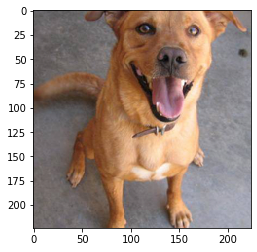

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(processed_image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [24]:
# TODO: Implement the code to predict the class from an image file

def prepare_input(image_path):
    input_image = Image.open(Path(image_path))
    input_tensor = process_image(input_image)
    input_minibatch = input_tensor.view((1, *input_tensor.shape))
    input_gpu = input_minibatch.to(device)
    return input_gpu


def extract_values(tensor):
    as_ndarray = tensor.cpu().detach().numpy()
    as_list = list(as_ndarray.flat)
    return as_list


def convert_ids_to_classes(ids, model):
    id_values = extract_values(ids)
    classes = [model.index2class[id] for id in id_values]
    return classes


def check_result(probabilities):
    prob_sum = torch.sum(probabilities)
    assert math.isclose(prob_sum, 1.0, rel_tol=1e-6), f"Probabilites don't sum up to 1, but to {prob_sum}."


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    input_tensor = prepare_input(image_path)
    model.eval()  
    with torch.no_grad():
        log_probabilities = model.forward(input_tensor)
    probabilities = torch.exp(log_probabilities)

    check_result(probabilities)
    
    top_probs, top_class_ids = torch.topk(input=probabilities, k=topk, dim=1)
    top_prob_values = extract_values(top_probs)
    top_classes = convert_ids_to_classes(top_class_ids, model)
    
    return top_prob_values, top_classes


test_image_path = Path("gentian.jpg")

loaded_model_dict, loaded_model = load_model(saved_model_path)
top_probs, top_classes = predict(test_image_path, loaded_model)
print(top_probs, top_classes, [cat_to_name[i] for i in top_classes], sep="\n")

[0.51006955, 0.23496404, 0.085779876, 0.02707624, 0.022800779]
['28', '3', '9', '43', '45']
['stemless gentian', 'canterbury bells', 'monkshood', 'sword lily', 'bolero deep blue']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

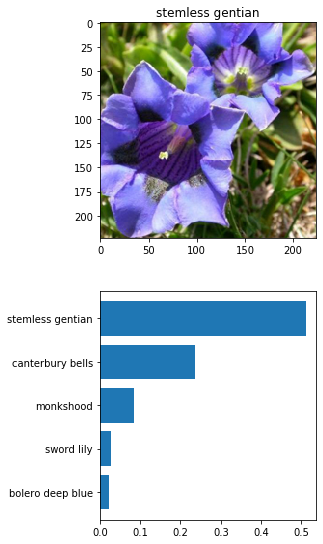

In [25]:
# TODO: Display an image along with the top 5 classes
top_class_names = [cat_to_name[cls] for cls in top_classes]

fig = plt.figure()

image_axes = fig.add_subplot(2, 1, 1)
image_axes.set_title(top_class_names[0])
imshow(process_image(Image.open(test_image_path)), image_axes);

stats_axes = fig.add_subplot(2, 1, 2)
stats_axes.barh(top_class_names[::-1], top_probs[::-1])

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

fig.get_size_inches()
fig.set_size_inches(3,7)